In [52]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import os
import time

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


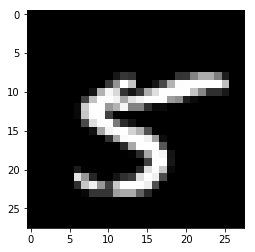

In [3]:
train_data,train_labels,eval_data,eval_labels = SP.load('mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [3]:
eval_data = SP.Scaling(eval_data,.8)

In [23]:
eval_data = SP.Exposure(eval_data,+60)

In [10]:
eval_data = SP.Rotation(eval_data,30)

In [5]:
eval_data = SP.Translation(eval_data,2)

0.76470596


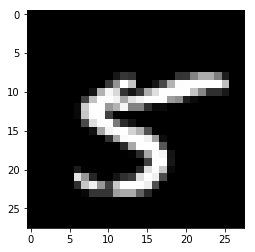

In [4]:
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [5]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)
  #print(logits.shape)
  #temp = tf.nn.top_k(input=logits,k=1,sorted=True,name=None)
  #print(temp[0])
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      
      #"classes": temp,
      "classes":tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"]),
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [6]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_test1")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [7]:
# print("started\n")
# # Train the model
# while 1:
#     curr_result = current_loss(0)
#     print(curr_result)
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.95:
#         break
# # Train the model
#     print("Training")
#     train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=256,
#       num_epochs=None,
#       shuffle=True)

#     mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=1,
#       hooks=[logging_hook])
    
#     #print(curr_result)
    
# print ("Finished")

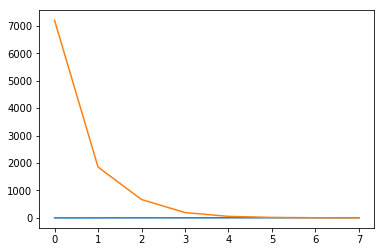

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [34]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
eval_data = SP.Scaling(eval_data,1.5)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [35]:
os.remove("./Optimisation Project/PY files/attack.npy")
np.save("./Optimisation Project/PY files/attack.npy", eval_data)
SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96958184, 'loss': 0.10504243, 'global_step': 20014}
######### Test accuracy #############
 {'accuracy': 0.7023, 'loss': 1.2921623, 'global_step': 20014}


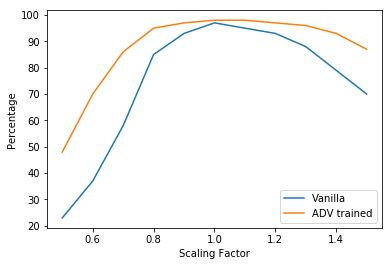

In [47]:
x = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
y = [23,37,58,85,93,97,95,93,88,79,70]
z = [48,70,86,95,97,98,98,97,96,93,87]

plt.plot(x,y,label="Vanilla")
plt.plot(x,z,label="ADV trained")
plt.xlabel("Scaling Factor")
plt.ylabel("Percentage")
plt.legend()
plt.show()

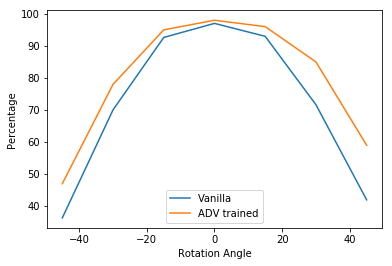

In [80]:
%%capture
x = [-45,-30,-15,0,15,30,45]
y = []
z = [47,78,95,98,96,85,59]
for i in x:
    train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
    eval_data = SP.Rotation(eval_data,i)
    y.append (SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier,1)[3])

y = np.array(y)
y = y[:,1]

y = np.array(y,dtype=float)
y = y*100

plt.plot(x,y,label="Vanilla")
plt.plot(x,z,label="ADV trained")
plt.xlabel("Rotation Angle")
plt.ylabel("Percentage")
plt.legend()
plt.show()

In [83]:
%%capture
x = [-100,-80,-60,-40,-20,0,20,40,60,80,100]
y = []
z = [97,98,98,98,98,98,98,98,98,97,92]

In [87]:
for i in x:
    train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
    eval_data = SP.Exposure(eval_data,i)
    os.remove("./Optimisation Project/PY files/attack.npy")
    np.save("./Optimisation Project/PY files/attack.npy", eval_data)
    time.sleep(2)
    y.append (SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier,1)[3])

In [84]:
y = np.array(y)
y = y[:,1]
y = np.array(y,dtype=float)
y = y*100

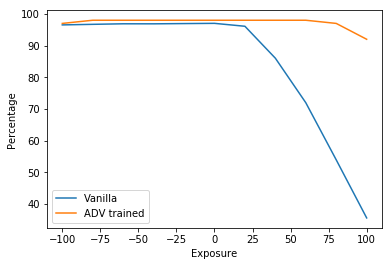

In [86]:
plt.plot(x,y,label="Vanilla")
plt.plot(x,z,label="ADV trained")
plt.xlabel("Exposure")
plt.ylabel("Percentage")
plt.legend()
plt.show()